# Segmentation 

This notebook shows how to use Stardist (Object Detection with Star-convex Shapes) as a part of a segmentation-classification-tracking analysis pipeline. 

The sections of this notebook are as follows:

1. Load images
2. Load model of choice and segment an initial image to test Stardist parameters
3. Batch segment a sequence of images

The data used in this notebook is timelapse microscopy data with h2b-gfp/rfp markers that show the spatial extent of the nucleus and it's mitotic state. 

This notebook uses the dask octopuslite image loader from the CellX/Lowe lab project.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from octopuslite import DaskOctopusLiteLoader
from stardist.models import StarDist2D
from stardist.plot import render_label
from csbdeep.utils import normalize
from tqdm import tqdm
from skimage.io import imsave
import json

## 1. Load images

In [ ]:
# define experiment ID and select a position
expt = 'ND0006'
pos = 'Pos10'
image_path = f'/home/nathan/data/{expt}/{pos}/{pos}_images'
images = DaskOctopusLiteLoader(image_path)

## 2. Load model and test segment single image 

In [10]:
model = StarDist2D.from_pretrained('2D_versatile_fluo')
model

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


StarDist2D(2D_versatile_fluo): YXC → YXC
├─ Directory: None
└─ Config2D(n_dim=2, axes='YXC', n_channel_in=1, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=[3, 3], unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=[2, 2], unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=[None, None, 1], net_mask_shape=[None, None, 1], train_shape_completion=False, train_completion_crop=32, train_patch_size=[256, 256], train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=[1, 0.2], train_class_weights=(1, 1), train_epochs=800, train_steps_per_epoch=400, train_learning_rate=0.0003, train_batch_size=8, train_n_val_patches=None, train_tensorboard=True, tr

In [20]:
# set test image index
frame = 100
# load test image 
img = images['gfp'][frame].compute()
# create 2-channel image
img = np.expand_dims(img, axis = -1)
img.shape

(1200, 1600, 1)

### 2.1 Test run and display initial results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


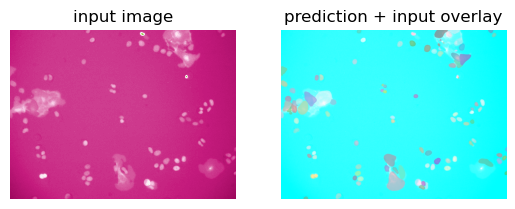

In [21]:
# initialise test segmentation
labels, details = model.predict_instances(normalize(img))

# plot input image and prediction
plt.clf()
plt.subplot(1,2,1)
plt.imshow(normalize(img[:,:,0]), cmap="PiYG")
plt.axis("off")
plt.title("input image")
plt.subplot(1,2,2)
plt.imshow(render_label(labels, img = img))
plt.axis("off")
plt.title("prediction + input overlay")
plt.show()

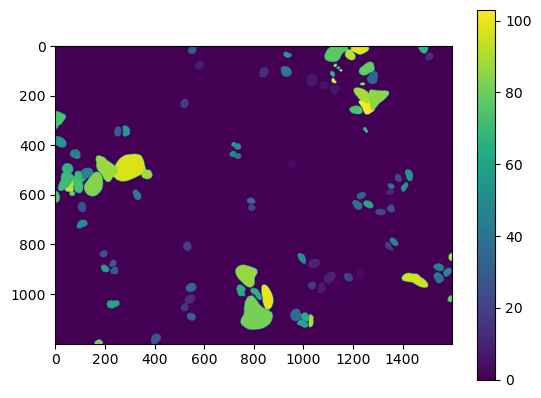

In [22]:
plt.imshow(labels)
plt.colorbar()
plt.show()

## 3. Batch segment a whole stack of images

In [ ]:
%%time
for expt, pos in zip(['ND0006'], ['Pos10']):
    print('Starting experiment position:', expt, pos)
    # load images
    image_path = f'/home/nathan/data/kraken/ras/{expt}/{pos}/{pos}_aligned'
    images = DaskOctopusLiteLoader(image_path)
    # set output directory for segmented images
    if not os.path.exists(image_path.replace('aligned', 'stardist_masks')):
        os.mkdir(image_path.replace('_aligned', '_stardist_masks'))
    for frame in tqdm(range(len(images['gfp'])), position=0, leave=True):
        img = images['gfp'][frame].compute()
        # create 2-channel image
        img = np.expand_dims(img, axis = -1)
        img.shape
        # predict labels using 2ch image
        labels, details = model.predict_instances(normalize(img))
        # set filename as mask format (channel099)
        fn = ((images.files('gfp')[frame].replace('_aligned', '_stardist_masks')).replace('.tif', '_stardist_masks.tif')).replace('channel001', 'channel099')
        # save out labelled image
        imsave(fn, labels.astype(np.uint16), check_contrast=False)
        # save out details array ## need to work on this to finesse
        fn = fn.replace('.tif', '_details.npz')
        np.savez(fn, details)

Starting experiment position: ND0006 Pos10
Using cropping: None


  1%|          | 5/859 [00:08<23:44,  1.67s/it]